In [1]:
from glob import glob

In [2]:
m1 = glob('data/xrd_data/*1min*')
m2 = glob('data/xrd_data/*2min*')
m4 = glob('data/xrd_data/*4min*')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def load_one(path):
    return pd.read_csv(path).set_index('2theta')

In [6]:
df_m1 = pd.concat([load_one(p) for p in m1], axis = 1)
df_m2 = pd.concat([load_one(p) for p in m2], axis = 1)
df_m4 = pd.concat([load_one(p) for p in m4], axis = 1)

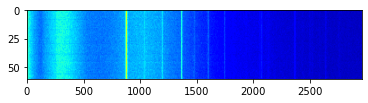

In [7]:
plt.imshow(df_m2.values.T, aspect = 10, cmap = 'jet')

In [8]:
patterns = df_m4.values.T

In [9]:
from xrdc import source_separation as sep

In [10]:
threshold = 20
bg_smooth = 20
bg_smooth_post = 20


background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = False,
                                 threshold = threshold, smooth_q = 1.7, smooth_neighbor_background = 0,
                                smooth_q_background = bg_smooth,
                                 bg_fill_method = 'simple')

(0, 0)


In [11]:
agged_background = np.mean(background, axis = 0)

background_variation = background - np.mean(background, axis = 0)

In [12]:
%matplotlib inline
sep.iplot_rows(patterns, background)

interactive(children=(IntSlider(value=29, description='i', max=59), Output(layout=Layout(height='550px'))), _d…

In [13]:
from xrdc.source_separation import gf

from sklearn.utils import resample

from scipy.stats import kstest

In [14]:
import slide_tricks as st

In [15]:
# agged_det = agg_2d(fast_q - background_variation)
# #agged_det = agg_2d(patterns - agged_background)

# agged_raw = agg_2d(patterns)

NameError: name 'agg_2d' is not defined

In [16]:
# def resample_2d(arr):
#     N = len(arr)
#     idx = np.arange(N).astype(int)
#     return arr[resample(idx), :]
    
    
# agged_det_boot_means = np.dstack([resample_2d(agged_det) for _ in range(100)]).mean(axis = 0).T

# agged_det_means = agged_det.mean(axis = 0)

# agged_det_stds = agged_det.std(axis = 0)

NameError: name 'resample_2d' is not defined

In [25]:
# !pip install fabio pyFAI ternary

In [26]:
from xrdc import fourier

(0.0, 2962.0)

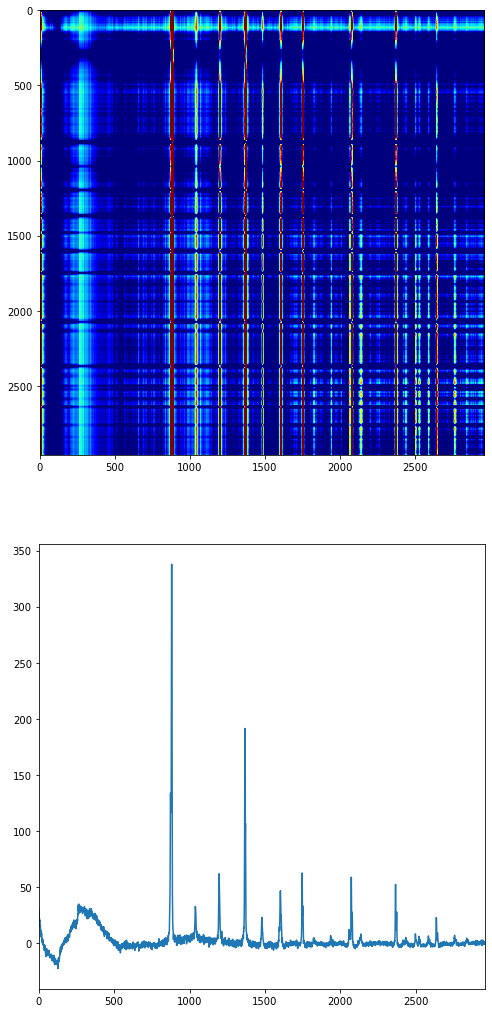

In [27]:
peak = fourier.lowpass_g(100, patterns[0])
peak = peak / peak.sum()

def mk_blocks_agg(arr):
    return st.sliding_window_view(arr, (len(arr), 7)).squeeze()[::7].mean(axis = 2)

def agg_2d(patterns):
    agged_2d = st.sliding_window_view(patterns, (len(patterns), 7)).squeeze().mean(axis = 2).T
    agged_2d = np.pad(agged_2d, ((0,), (3,)), mode = 'edge')
    return agged_2d

def conv2d(a, b):
    return np.vstack([np.convolve(p, b, 'same') for p in a])

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(8, 18)

#agged_det = agg_2d((fast_q - background_variation)[:30])

det = fast_q - background_variation

block_means = np.median(conv2d(det, peak), axis = 0)#.mean(axis = 0)#mk_blocks_agg(agged_det).mean(axis = 1)
block_stds = np.median(np.sqrt((conv2d(det, peak) - block_means)**2), axis = 0)
#.std(axis = 0)#mk_blocks_agg(agged_det).std(axis = 1)

b = block_means.reshape((block_means.shape[0], 1))

pairwise_diffs = block_means - b
#pairwise_diffs = gf(pairwise_diffs, 4) * 2

pairwise_stds = np.sqrt(block_stds**2 + block_stds.reshape((block_stds.shape[0], 1))**2)
#pairwise_stds = gf(pairwise_stds, 4) 

ratio = pairwise_diffs / (pairwise_stds)
ratio = gf(ratio, (3, 0))

a,b  = 2, 1
plt.subplot(a,b, 1)
plt.imshow(
    ((ratio)),
    cmap = 'jet', vmax = 2, vmin = 0, interpolation = 'none')
#plt.colorbar()

plt.subplot(a,b, 2)
plt.plot(fast_q.mean(axis = 0))
plt.xlim(0, len(patterns[0]))

In [28]:
rowmask = (np.median(fast_q, axis = 0) < np.percentile(np.median(fast_q, axis = 0), 50))
rowmask[:1300] = False

imask = np.arange(len(ratio))[rowmask]

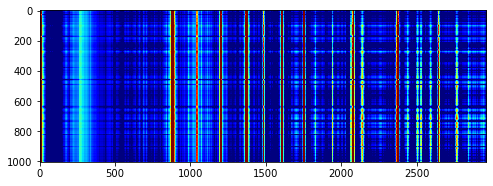

In [29]:
mpl.rcParams['figure.figsize'] =(8, 5)

plt.imshow(ratio[imask, :], cmap = 'jet', aspect = 1, vmin = 0, vmax = 2, interpolation = 'none')

In [536]:
std_agg_ratio = pairwise_diffs[imask][::10].sum(axis = 0) /\
np.sqrt((pairwise_stds[imask][::10] * pairwise_stds[imask][::10]).sum(axis = 0))
#pairwise_stds[imask].sum(axis = 0) / np.sqrt((pairwise_stds[imask] * pairwise_stds[imask]).sum(axis = 0))

In [525]:
pairwise_diffs[imask].sum(axis = 0) / np.sqrt((pairwise_stds[imask] * pairwise_stds[imask]).sum(axis = 0))

array([65.2219463 , 75.8807336 , 80.07423779, ...,  0.85040742,
        1.89726875,  1.4599608 ])

In [523]:
pairwise_stds[imask].sum(axis = 0) / np.sqrt((pairwise_stds[imask] * pairwise_stds[imask]).sum(axis = 0))

array([30.65999954, 31.03052877, 31.28178807, ..., 29.57530974,
       29.48138646, 29.35243862])

In [524]:
np.sqrt((pairwise_stds[imask] * pairwise_stds[imask]).sum(axis = 0))

array([176.95309446, 197.38140562, 220.95406316, ..., 148.24733472,
       146.71225367, 144.74609171])

In [547]:
std_agg_ratio

array([20.2148906 , 23.61954248, 24.99913139, ...,  0.06975248,
        0.39296443,  0.25429424])

<IPython.core.display.Javascript object>


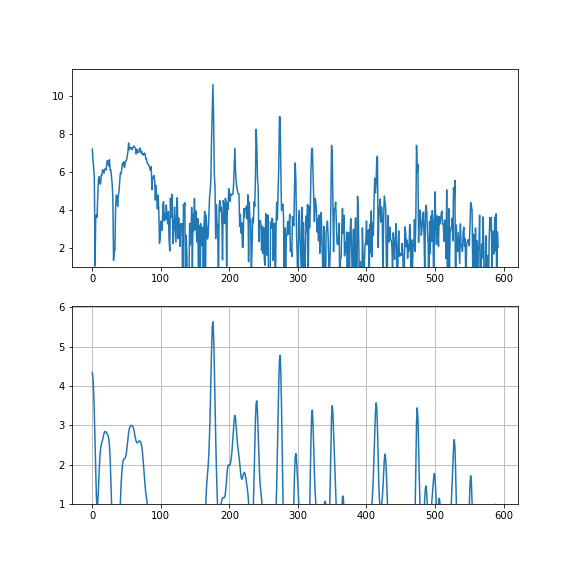

In [584]:
%matplotlib notebook
skip = 5
mpl.rcParams['figure.figsize'] =(8, 8)
plt.subplot(a, b, 1)
#plt.plot(100 * fast_q.mean(axis = 0) / 20)
plt.grid()
plt.plot(np.log2(np.abs(100 * fast_q.mean(axis = 0) / 20))[::skip])
plt.grid()
plt.ylim(1, None)

plt.subplot(a, b, 2)
plt.plot(
    gf(np.log2(np.abs(std_agg_ratio))[::skip], 2)
)
plt.ylim(1, None)
plt.grid()

<IPython.core.display.Javascript object>


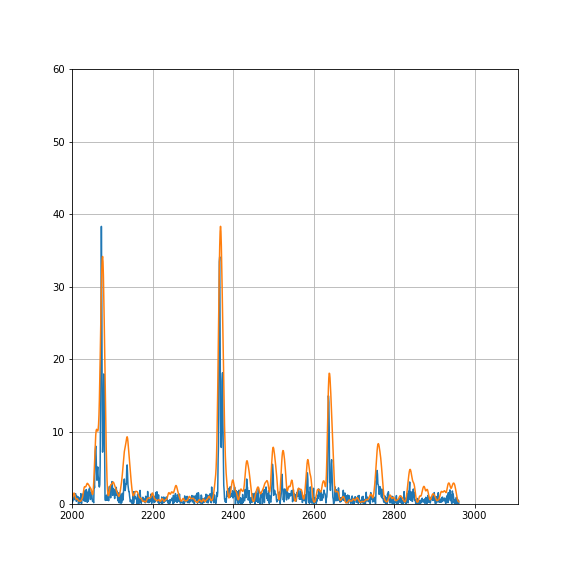

In [585]:
%matplotlib notebook
skip = 5
mpl.rcParams['figure.figsize'] =(8, 8)
#plt.subplot(a, b, 1)
#plt.plot(100 * fast_q.mean(axis = 0) / 20)
plt.plot((np.abs(13 * fast_q.mean(axis = 0) / 20)))
# plt.grid()
# plt.ylim(1, None)


# plt.subplot(a, b, 2)
plt.plot(gf(np.abs(std_agg_ratio), 2))
plt.ylim(0, 60)
plt.xlim(2000, None)
plt.grid()

<IPython.core.display.Javascript object>


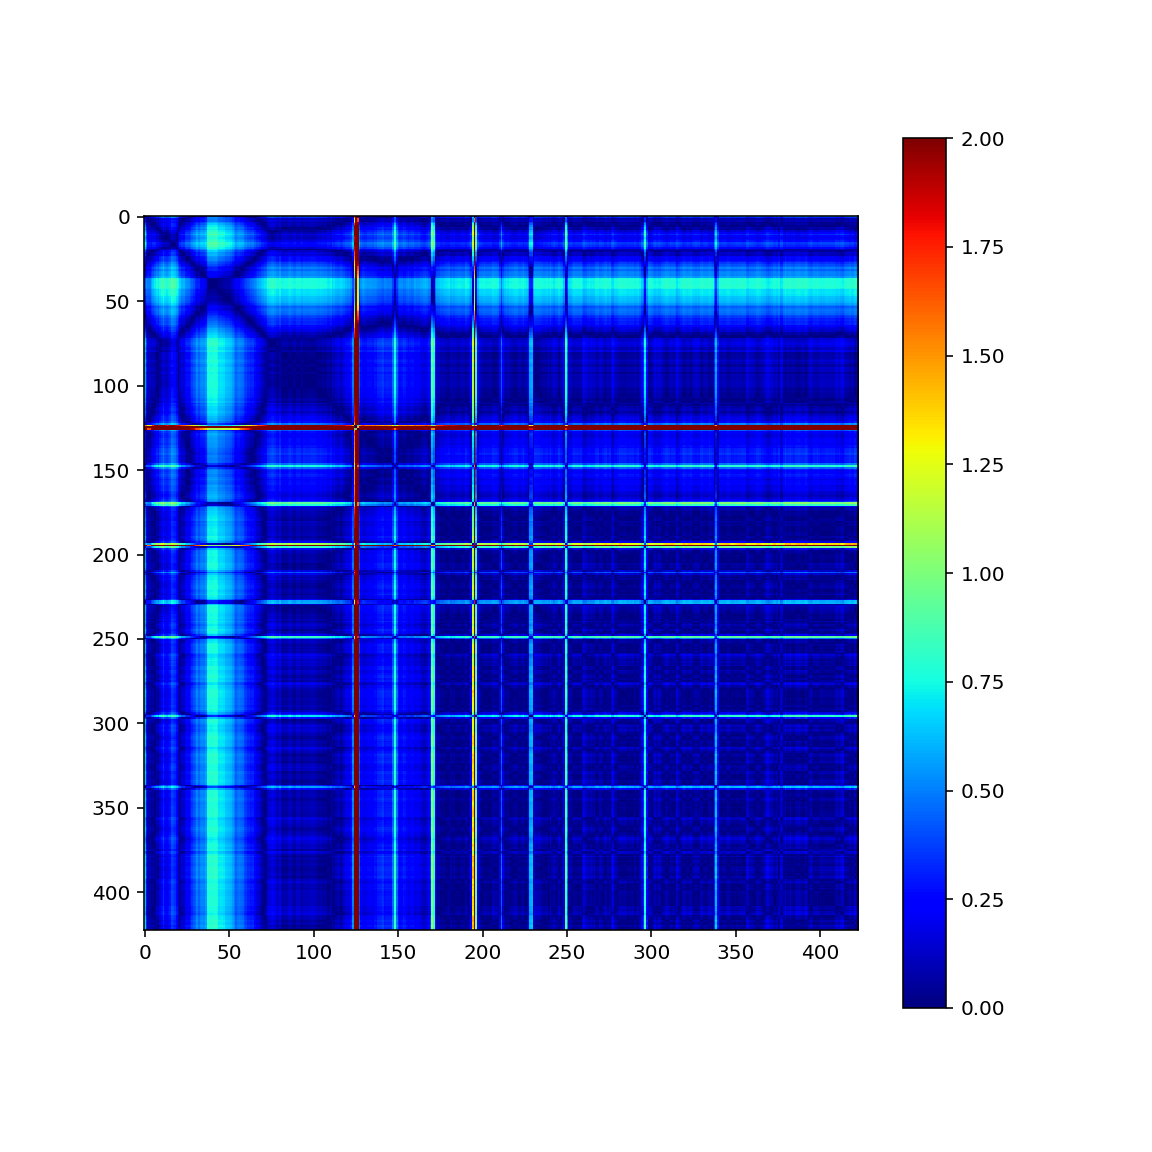

In [486]:
block_means = mk_blocks_agg(agged_det).mean(axis = 1)
block_stds = mk_blocks_agg(agged_det).std(axis = 1)

b = block_means.reshape((block_means.shape[0], 1))

pairwise_diffs = block_means - b

pairwise_stds = np.sqrt(block_stds**2 + block_stds.reshape((block_stds.shape[0], 1))**2)

plt.imshow(
    (np.abs(pairwise_diffs / (1 + pairwise_stds))),
    cmap = 'jet', vmax = 2, interpolation = 'none')
plt.colorbar()

<IPython.core.display.Javascript object>


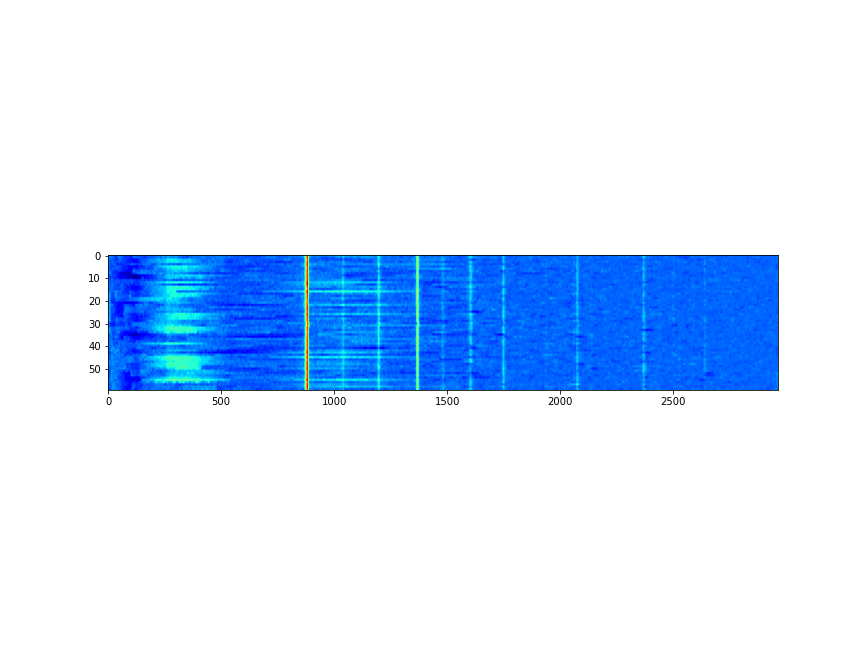

In [139]:
plt.imshow(agged_det, aspect = 10, cmap = 'jet')

In [115]:
patterns.shape

(60, 2962)

<IPython.core.display.Javascript object>


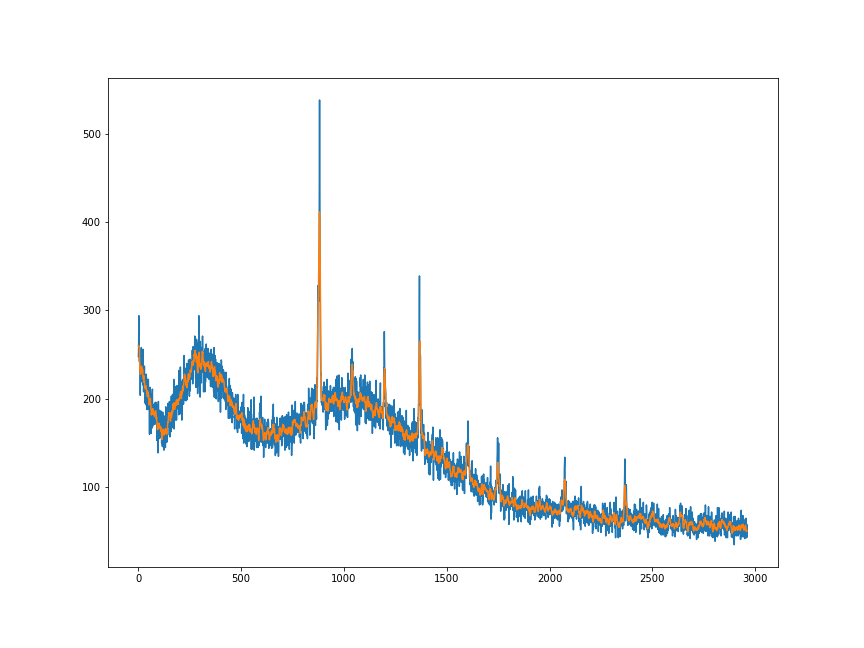

In [119]:
%matplotlib notebook
i = 10
plt.plot(patterns[i])
plt.plot(agged_2d[i])

<IPython.core.display.Javascript object>


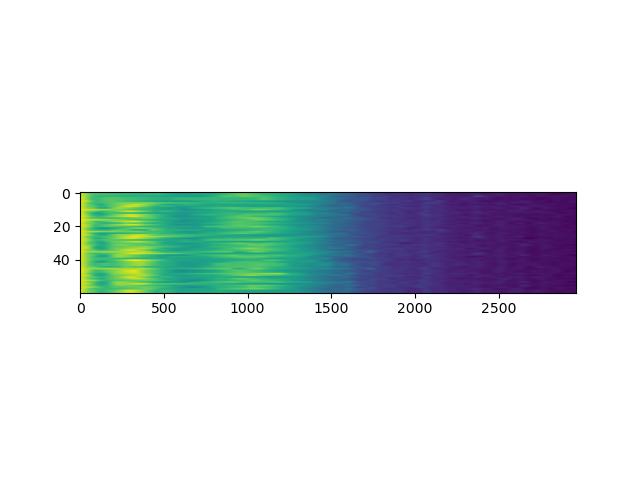

In [56]:
plt.imshow(resample_2d(background), aspect = 10)

In [48]:
resample(background)

array([[241.00335394, 240.96724496, 240.89513595, ...,  56.64770525,
         56.65068734,  56.65210755],
       [242.62725544, 242.57427965, 242.46858673, ...,  48.48604468,
         48.46802182,  48.45887438],
       [243.65127497, 243.60012853, 243.49803882, ...,  58.03430726,
         58.0443223 ,  58.049336  ],
       ...,
       [244.68531166, 244.65228906, 244.5863229 , ...,  56.28359358,
         56.29927946,  56.30715462],
       [244.56632174, 244.52991812, 244.45719679, ...,  56.35119478,
         56.34811552,  56.34657364],
       [243.63488211, 243.59735108, 243.52235509, ...,  54.22366631,
         54.21297005,  54.20761115]])

In [46]:
N = len(patterns)
aggregate_uncertainty = np.sqrt((fast_T.std(axis = 0)**2 + background.std(axis = 0)**2) / N)
background = gf(background, (0, bg_smooth_post))
aggregate_uncertainty = gf(aggregate_uncertainty, bg_smooth_post)

<IPython.core.display.Javascript object>


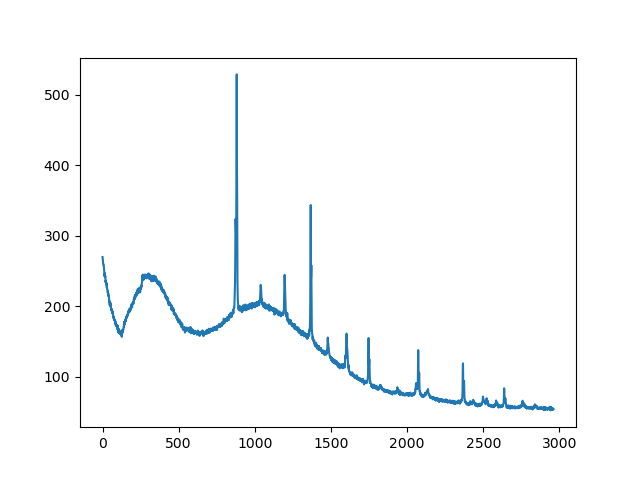

In [29]:
%matplotlib notebook
plt.plot(df_m4.mean(axis = 1).values)